# Example: MRI Application
In this example we take an image of the Shepp-Logan phantom and we evaluate the
forward NUFFT on a set of points defining a radial *k*-space trajectory. Then,
we use the the adjoint NUFFT to recover the image from the radial *k*-space
data.

## Prepare data

Let's begin by creating an example image. We will use the Shepp-Logan phantom,
provided by [scikit-image](https://pypi.org/project/scikit-image/).

In [1]:
import skimage.data
import skimage.transform
import tensorflow as tf

grid_shape = [256, 256]
image = tf.convert_to_tensor(skimage.transform.resize(
    skimage.data.shepp_logan_phantom(), grid_shape).astype('float32'), dtype=tf.complex64)

print("image: \n - shape: {}\n - dtype: {}".format(image.shape, image.dtype))

image: 
 - shape: (256, 256)
 - dtype: <dtype: 'complex64'>


Let us also create a *k*-space trajectory. In this example we will create a
radial trajectory using the
[TensorFlow MRI](https://pypi.org/project/tensorflow-mri/) package.

In [2]:
import tensorflow_mri as tfmr

points = tfmr.radial_trajectory(base_resolution=256, views=233)
points = tf.reshape(points, [-1, 2])

print("points: \n - shape: {}\n - dtype: {}\n - range: [{}, {}]".format(
    points.shape, points.dtype, tf.math.reduce_min(points), tf.math.reduce_max(points)))

points: 
 - shape: (119296, 2)
 - dtype: <dtype: 'float32'>
 - range: [-3.141521453857422, 3.1415927410125732]


The trajectory should have shape `[..., M, N]`, where `M` is the number of
points and `N` is the number of dimensions. Any additional dimensions `...` will
be treated as batch dimensions.

Batch dimensions for `image` and `traj`, if any, will be broadcasted.

Spatial frequencies should be provided in radians/voxel, ie, in the range
`[-pi, pi]`.

Finally, we'll also need density compensation weights for our set of nonuniform
points. These are necessary in the adjoint transform, to compensate for the fact
that the sampling density in a radial trajectory is not uniform. Here we use
`tensorflow-mri` to calculate these weights.

In [3]:
weights = tfmr.radial_density(base_resolution=256, views=233)
weights = tf.reshape(weights, [-1])

print("weights: \n - shape: {}\n - dtype: {}".format(weights.shape, weights.dtype))

weights: 
 - shape: (119296,)
 - dtype: <dtype: 'float32'>


## Forward transform (image to *k*-space)

Next, let's calculate the k-space coefficients for the given image and trajectory points (image to k-space transform).

In [4]:
import tensorflow_nufft as tfft

kspace = tfft.nufft(image, points,
                    transform_type='type_2',
                    j_sign='negative')

print("kspace: \n - shape: {}\n - dtype: {}".format(kspace.shape, kspace.dtype))

kspace: 
 - shape: (119296,)
 - dtype: <dtype: 'complex64'>


We are using a type-2 transform (uniform to nonuniform) and a negative sign for
the imaginary unit (signal domain to frequency domain). These are the default
values for `transform_type` and `j_sign`, so providing them was not necessary
in this case.

## Adjoint transform (*k*-space to image)

We will now perform the adjoint transform to recover the image given the
*k*-space data. In this case, we will use a type-1 transform (nonuniform to
uniform) and a positive sign for the imaginary unit (frequency domain to signal
domain). Also note that, prior to evaluating the NUFFT, we will compensate for
the nonuniform sampling density by simply dividing the *k*-space samples by the
density weights. Finally, for type-1 transforms we need to specify an additional
`grid_shape` argument, which should be the size of the image. If there are any
batch dimensions, `grid_shape` should **not** include them.

In [5]:
# Apply density compensation.
comp_kspace = kspace / tf.cast(weights, tf.complex64)

recon = tfft.nufft(comp_kspace, points,
                   transform_type='type_1',
                   j_sign='positive',
                   grid_shape=grid_shape)

print("recon: \n - shape: {}\n - dtype: {}".format(recon.shape, recon.dtype))

recon: 
 - shape: (256, 256)
 - dtype: <dtype: 'complex64'>


Finally, let's visualize the images.

Text(0.5, 1.0, 'Image after forward\nand adjoint NUFFT')

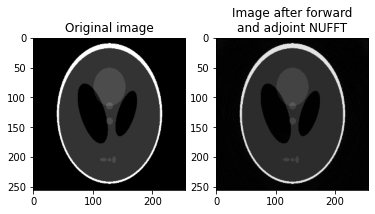

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(tf.abs(image), cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(tf.abs(recon), cmap='gray')
ax[1].set_title("Image after forward\nand adjoint NUFFT")